In [20]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
r.status()
from IPython.html.widgets import interact, interactive
from IPython.display import display

---------------------------------
Rebound version:     	1.1.0
Build on:            	Jun 24 2015 10:13:57
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


## Simulated data:

In [66]:
def check(thetac):
    if len(thetac)==3:
        e = np.power(thetac[1]**2+thetac[2]**2,1./2.)
        if e>0.4 or e<=0.:
            return 0
    return 1

def particleSetupDict(thetap):
    # Defaults
    a = 4.; anom = 0.; omega = -np.pi/2.;
    for i, name in enumerate(theta_names):
        if name == "a":
            a = thetap[i]
        if name == "anom":
            anom = thetap[i]
    return r.Particle(primary=r.particles[0],m=1e-3,a=a,e=0.,anom=anom,omega=omega)


def particleSetup(thetap):
    if len(thetap)==4:
        return r.Particle(primary=r.particles[0],m=1e-3,a=thetap[0],e=np.clip(thetap[1],0.,1.),anom=thetap[2],omega=thetap[3])
    elif len(thetap)==2:
        return r.Particle(primary=r.particles[0],m=1e-3,a=thetap[0],e=0.,anom=thetap[1],omega=-np.pi/2.)
    elif len(thetap)==3:
        return r.Particle(primary=r.particles[0],m=thetap[2],a=thetap[0],e=0.,anom=thetap[1],omega=-np.pi/2.)
    else:
        return r.Particle(primary=r.particles[0],m=1e-3,a=thetap[0],e=0.2,anom=0.,omega=-np.pi/2.)

def getRV(thetar):
    r.reset()
    r.add(m=1.)
    r.add(particleSetupDict(thetar))
    r.move_to_com()
    ps = r.particles
    rvs = np.zeros(len(data_t))
    for i,t in enumerate(data_t):
        r.integrate(t)
        rvs[i] = ps[0].vx
    return rvs

def generateObs(thetao, data_N):
    global data_t, data_rv, data_err, data_theta, N_param
    data_theta = np.array(thetao).copy()
    N_param = len(thetao)
    data_t = np.linspace(0.,50.,data_N)+0.0005*np.random.rand(data_N)
    error_scale = 0.00004
    data_rv = getRV(thetao)+np.random.normal(0.,error_scale,data_N)
    data_err = np.full(data_N,error_scale)

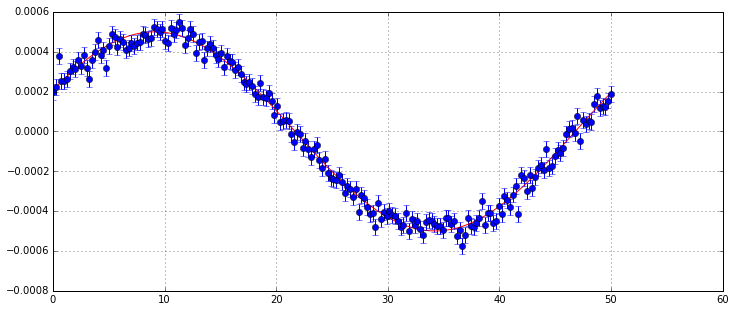

In [67]:
theta_names = ["a", "anom"]
test =  [4.,2.]
generateObs(test,data_N=200)
fig1 = plt.figure(figsize=(12,5))
plt.plot(data_t, getRV(test), color="r");
plt.errorbar(data_t, data_rv, yerr=data_err, fmt="bo")
plt.grid()

## Setting up simulations

Fails: 0. Acceptance rate: 86.4%


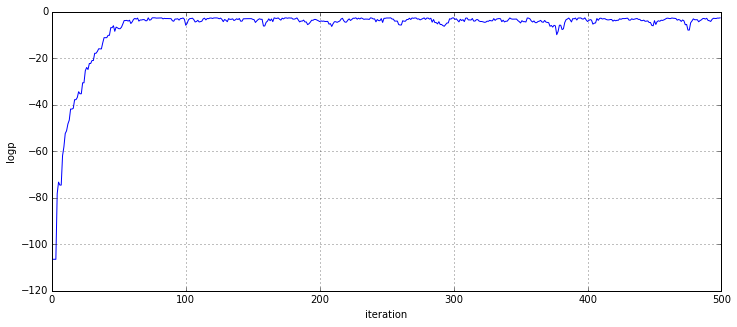

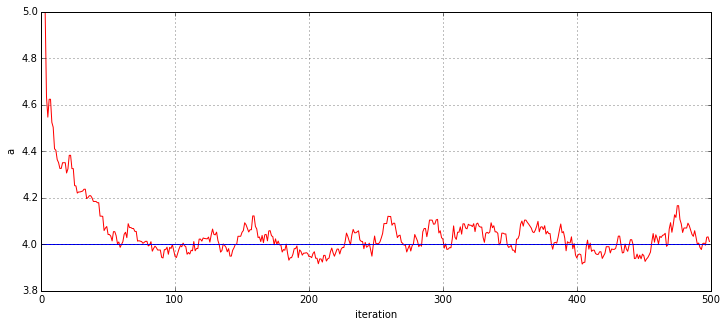

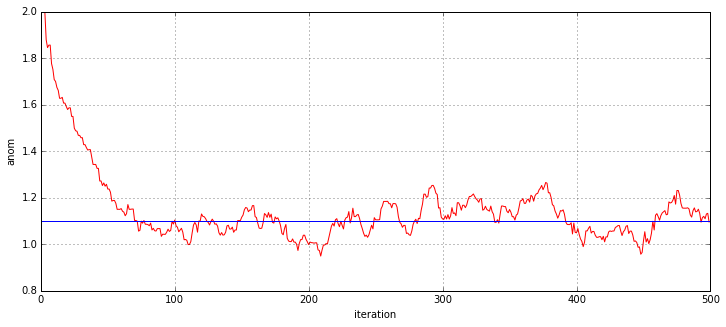

In [71]:
N = 2
def varid2(l,k):
    if k>l:
        raise Exception("error")
    if l>=N_param:
        raise Exception("error")
    var = l*(l+1)/2+k
    return var*N+N+N*N_param
def varid1(l):
    if l>=N_param:
        raise Exception("error")
    return N*l+N
    
def simulation(cart):
    r.reset()
    N_param = len(cart)
    r.N_megnopp = N_param 
    r.add(m=1.)
    op = particleSetup(cart)
    r.add(op)
    r.move_to_com()
    N = r.N
    r.init_megno(0.)
    ps = r.particles
    
    delta = 1e-4
    # First order
    for l in range(N_param):
        cart2 = cart.copy()
        cart2[l] += delta/2.
        mp = particleSetup(cart2)
        cart2 = cart.copy()
        cart2[l] -= delta/2.
        mm = particleSetup(cart2)

        vari = varid1(l)+1
        ps[vari].x  = (mp.x  - mm.x  )
        ps[vari].y  = (mp.y  - mm.y  )
        ps[vari].z  = (mp.z  - mm.z  )
        ps[vari].vx = (mp.vx - mm.vx )
        ps[vari].vy = (mp.vy - mm.vy )
        ps[vari].vz = (mp.vz - mm.vz )
        
    # Second order
    for l in range(N_param):
        for k in range(l+1):
            fac = 2.
            cart2 = cart.copy()
            cart2[l] += delta/fac
            cart2[k] += delta/fac
            mpp = particleSetup(cart2)
            cart2 = cart.copy()
            cart2[l] += delta/fac
            cart2[k] -= delta/fac
            mpm = particleSetup(cart2)
            cart2 = cart.copy()
            cart2[l] -= delta/fac
            cart2[k] += delta/fac
            mmp = particleSetup(cart2)
            cart2 = cart.copy()
            cart2[l] -= delta/fac
            cart2[k] -= delta/fac
            mmm = particleSetup(cart2)
            
            vari2 = varid2(l,k)+1
            ps[vari2].x  = mpp.x  - mpm.x  - mmp.x  + mmm.x
            ps[vari2].y  = mpp.y  - mpm.y  - mmp.y  + mmm.y 
            ps[vari2].z  = mpp.z  - mpm.z  - mmp.z  + mmm.z 
            ps[vari2].vx = mpp.vx - mpm.vx - mmp.vx + mmm.vx
            ps[vari2].vy = mpp.vy - mpm.vy - mmp.vy + mmm.vy
            ps[vari2].vz = mpp.vz - mpm.vz - mmp.vz + mmm.vz
    
    
    ##################################################################
    # INTEGRATION
    logps   = 0.
    logp_d  = np.zeros(N_param)
    logp_d2 = np.zeros((N_param*(N_param+1)/2,2))
    for i,t in enumerate(data_t):
        r.integrate(t)
        dv = ps[0].vx-data_rv[i]
        derri = 1./(2.*(data_err[i]**2))
        logps  += -dv**2*derri
        for k in range(N_param):
            vari1 = varid1(k)
            logp_d[k] += -2.*ps[vari1].vx/delta * dv*derri
        _id = 0
        for l in range(N_param):
            for k in range(l+1):
                vari2 = varid2(l,k)
                vari1l = varid1(l)
                vari1k = varid1(k)
                logp_d2[_id][0] += -2.*(ps[vari1l].vx * ps[vari1k].vx)/(delta*delta)*derri
                # Expectation value removes next line
                logp_d2[_id][1] += -2.*(ps[vari2].vx * dv)/(delta*delta)*derri
                _id += 1
    
    logp_d2m = np.zeros((N_param,N_param))
    _id = 0
    for l in range(N_param):
        for k in range(l+1):
            fdd = logp_d2[_id][0] + logp_d2[_id][1]
            logp_d2m[l,k] = fdd
            logp_d2m[k,l] = fdd
            _id +=1
    
    return logps, logp_d, logp_d2m


def softabs(hessians):
    lam, Q = np.linalg.eig(-hessians)
    lam_twig = lam*1./np.tanh(alpha*lam)
    H_twig = np.dot(Q,np.dot(np.diag(lam_twig),Q.T))    
    return H_twig

def mcmc(theta,N_steps):
    N_param = len(theta)
    theta = np.array(theta)
    errs = np.zeros(N_steps)
    chain = np.zeros((N_steps,N_param))
    first = 1
    failcount = 0
    accepted = 0
    for i in range(N_steps):
        if first==1:
            first = 0
            logp, gradient, hessian = simulation(theta)
            G     = softabs(hessian)
            Ginv  = np.linalg.inv(G)
            Ginvsqrt = np.linalg.cholesky(Ginv)    
            mu    = theta + epsilon**2 * np.dot(Ginv, gradient)/2.

        thetastar = mu + epsilon * np.dot(Ginvsqrt, np.random.normal(0.,1.,N_param))

        logpstar, gradientstar, hessianstar = simulation(thetastar)        
        Gstar     = softabs(hessianstar)
        Ginvstar  = np.linalg.inv(Gstar)
        Ginvsqrtstar = np.linalg.cholesky(Ginvstar)
        mustar = thetastar + epsilon**2 * np.dot(Ginvstar, gradientstar)/2.

        q_ts_t = stats.multivariate_normal.logpdf(thetastar,mean=mu, cov=epsilon**2*Ginv)
        q_t_ts = stats.multivariate_normal.logpdf(theta,mean=mustar, cov=epsilon**2*Ginvstar)
        #print thetastar
        #print mustar
        #print logpstar, logp, q_t_ts, q_ts_t
        #print logpstar- logp, q_t_ts- q_ts_t
        
        #q_ts_t = 1.
        #q_t_ts = 1.
        try:
            pass
        except:
            failcount += 1
            pass
        else:
            z = np.random.uniform()
            #print i, np.exp(logpstar-logp+q_t_ts-q_ts_t), np.exp(logpstar-logp), z, min(1.,np.exp(logpstar-logp+q_t_ts-q_ts_t)) > z
            if min(1.,np.exp(logpstar-logp+q_t_ts-q_ts_t)) > z:
                accepted += 1
                theta    = thetastar.copy()
                logp     = logpstar
                gradient = gradientstar.copy()
                hessian  = hessianstar.copy()
                G        = Gstar.copy()
                Ginv     = Ginvstar.copy()
                Ginvsqrt = Ginvsqrtstar.copy()
                mu       = mustar.copy()
        chain[i] = theta
        errs[i] = logp

    print "Fails: %d. Acceptance rate: %.1f%%" % (failcount, float(accepted)/float(N_steps)*100.)
    return errs, chain
    

N_steps                  = 500
epsilon                  = 0.75   
alpha                    = 10.1         # Softabs alpha
theta_names              = ["a", "anom"]
generateObs([4., 1.1],data_N=10)
errs, chain              = mcmc([5.,2.],N_steps)

fig1 = plt.figure(figsize=(12,5))
plt.xlabel("iteration"); plt.ylabel("logp");
plt.plot(range(N_steps), errs, color="b");
plt.grid()
for i in range(N_param):
    fig1 = plt.figure(figsize=(12,5))
    plt.xlabel("iteration"); plt.ylabel(theta_names[i]);
    plt.plot(range(N_steps), chain[:,i], color="r");
    plt.plot([0,N_steps-1], [data_theta[i],data_theta[i]], color="b");
    plt.grid()

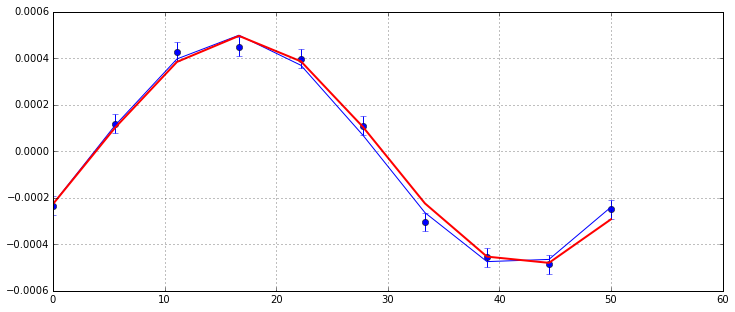

In [72]:
def widgetplot(ind):
    fig1 = plt.figure(figsize=(12,5))
    plt.errorbar(data_t, data_rv, yerr=data_err, fmt="bo")
    plt.plot(data_t, getRV(data_theta), color="b");
    plt.plot(data_t, getRV(chain[int(ind),:]), color="r", lw=2);
    plt.grid()

w = interactive(widgetplot, ind=(0,N_steps-1))
display(w)